## Install Some Library

In [ ]:
!pip install emoji
!pip install Sastrawi
!pip install google-play-scraper
!pip install umap-learn
!pip install simplemma

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.9/586.9 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.2/67.2 MB 9.9 MB/s eta 0:00:00


## Import Library

In [ ]:
import string
import re
import emoji
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import warnings
import umap
import simplemma
from umap import UMAP
from google_play_scraper import Sort, reviews
from collections import Counter
warnings.filterwarnings('ignore')
sns.set(style='white', palette='muted', color_codes=True)

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import FreqDist
from gensim.models import Word2Vec
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary

from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Data Collection

In [ ]:
result, continuation = reviews(
    'com.Info_BMKG',
    lang='id',
    country='id',
    sort=Sort.MOST_RELEVANT,
    count=5000,
    filter_score_with=None
)

In [ ]:
df = pd.DataFrame(np.array(result), columns=['review'])
df = df.join(pd.DataFrame(df.pop('review').tolist()))
df.head()

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,2e944409-c382-44f3-9fa3-969fff1ffda3,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Aplikasinya cukup bagus. Cuma sedikit saran aj...,5,14,3.3.2,2024-11-10 07:50:44,None,NaT,3.3.2
1,68781947-21c9-4bad-ac54-a1bab7a84797,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi sangat membantu, tapi sayang.a daerah...",5,0,3.3.2,2024-11-17 13:35:55,None,NaT,3.3.2
2,7528e062-9548-462c-a0eb-3ec7ddecd921,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Cukup akurat.. Tapi tolong untuk cuaca di bagu...,5,63,3.3.1,2024-10-28 08:29:53,None,NaT,3.3.1
3,5c557312-5d5c-421e-8771-91f3802ce7ee,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Buat notifikasi pop up saat gempa terjadi di w...,3,12,3.3.2,2024-11-08 06:06:29,None,NaT,3.3.2
4,a76aceba-6e1f-43bd-8436-791a7070de95,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Untuk informasi kualitas udara mohon diperluas...,3,1,3.3.2,2024-11-12 10:26:44,None,NaT,3.3.2


In [ ]:
df.to_csv('bmkg_raw_data.csv', index=False)

In [ ]:
df.sort_values(by='at', ascending=False, inplace=True)
df

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
1,68781947-21c9-4bad-ac54-a1bab7a84797,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi sangat membantu, tapi sayang.a daerah...",5,0,3.3.2,2024-11-17 13:35:55,None,NaT,3.3.2
4633,66cb3835-e3a0-4e2f-9dcf-99c8f6deb94e,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,sangat membantu,3,0,2.4.1,2024-11-17 08:04:24,None,NaT,2.4.1
50,eaa53d52-9a22-4673-9399-046f8b95d0ff,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Kami meŕasa terbantu dlm keadaan dan kondisi a...,5,0,3.3.1,2024-11-16 21:48:15,None,NaT,3.3.1
154,5e7a0c5f-1136-4d52-b8b9-8f6c4ea3c36a,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,notifnya kenapa mati ya 2 hari ini,4,144,3.3.2,2024-11-16 14:01:15,"Hai Budi, terima kasih atas ulasanmu. Kritik d...",2023-02-02 01:53:11,3.3.2
7,9fe009de-0f01-460c-b1aa-0c361c1f03ac,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Sangat membantu utk mengetahui cuaca dan gempa...,5,0,3.3.2,2024-11-15 21:27:21,None,NaT,3.3.2
...,...,...,...,...,...,...,...,...,...,...,...
3134,0666d0e3-9b0b-424d-9200-3b6fefba7b66,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Bagus sekali karena saya tinggal di rawan gemp...,5,0,2.4,2018-09-15 11:26:47,None,NaT,2.4
3029,91960812-894e-4406-9334-4fc725e7ac3b,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Tolong gan perbaharui mengenai hujan di indone...,3,1,2.4,2018-09-14 17:21:04,None,NaT,2.4
2976,d0ee1aac-29d7-48bf-aefa-73e4253f7621,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,Apk ini sangat membantu .dan saya dpat mengeta...,5,1,2.4,2018-09-14 12:26:23,None,NaT,2.4
3200,97e9cec9-5910-4ea2-8753-543eb940375f,Pengguna Google,https://play-lh.googleusercontent.com/EGemoI2N...,"Aplikasi keren dari BMKG, membantu sekali.",5,1,2.4,2018-09-14 02:53:36,None,NaT,2.4


## Data Understanding

In [ ]:
df.shape

(5000, 11)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 1 to 3093
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              5000 non-null   object        
 1   userName              5000 non-null   object        
 2   userImage             5000 non-null   object        
 3   content               5000 non-null   object        
 4   score                 5000 non-null   int64         
 5   thumbsUpCount         5000 non-null   int64         
 6   reviewCreatedVersion  3988 non-null   object        
 7   at                    5000 non-null   datetime64[ns]
 8   replyContent          50 non-null     object        
 9   repliedAt             50 non-null     datetime64[ns]
 10  appVersion            3988 non-null   object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 468.8+ KB


In [ ]:
df = df.iloc[:, 3:5]
df.reset_index(drop=True, inplace=True)
df.head()

,content,score
0,"Aplikasi sangat membantu, tapi sayang.a daerah...",5
1,sangat membantu,3
2,Kami meŕasa terbantu dlm keadaan dan kondisi a...,5
3,notifnya kenapa mati ya 2 hari ini,4
4,Sangat membantu utk mengetahui cuaca dan gempa...,5


In [ ]:
def sentiment(score):
  if score <= 2:
    return 'Negative'
  elif score >= 4:
    return 'Positive'

df['score'] = df['score'].apply(lambda x: sentiment(x))

In [ ]:
df['score'].value_counts()

,count
score,
Positive,3300
Negative,1130


In [ ]:
df.head()

,content,score
0,"Aplikasi sangat membantu, tapi sayang.a daerah...",Positive
1,sangat membantu,None
2,Kami meŕasa terbantu dlm keadaan dan kondisi a...,Positive
3,notifnya kenapa mati ya 2 hari ini,Positive
4,Sangat membantu utk mengetahui cuaca dan gempa...,Positive


## Data Cleansing

In [ ]:
df.isnull().sum()

,0
content,0
score,570


In [ ]:
df.dropna(inplace=True)

In [ ]:
df.shape

(4430, 2)

## Data Preprocessing

In [ ]:
# casefolding
def casefolding(content):
  content = content.lower()
  return content

df['content'] = df['content'].apply(lambda x: casefolding(x))

In [ ]:
df.head()

,content,score
0,"aplikasi sangat membantu, tapi sayang.a daerah...",Positive
2,kami meŕasa terbantu dlm keadaan dan kondisi a...,Positive
3,notifnya kenapa mati ya 2 hari ini,Positive
4,sangat membantu utk mengetahui cuaca dan gempa...,Positive
5,ut cuaca cukup akurat,Positive


In [ ]:
# cleaning
def cleaning(content):
  content = content.strip(' ') # menghapus spasi di awal dan di akhir
  content = re.sub(r'\d+', '', content) # menghapus angka
  content = content.translate(str.maketrans('','', string.punctuation)) # menghapus punctuation
  content = re.sub(r'\b[a-zA-Z]\b', '', content) # menghapus kata yang hanya terdiri dari satu huruf
  content = re.sub(r'\s+', ' ', content) # menghapus spasi berlebih
  return content

df['content'] = df['content'].apply(lambda x: cleaning(x))

In [ ]:
df.head()

,content,score
0,aplikasi sangat membantu tapi sayanga daerah s...,Positive
2,kami meŕasa terbantu dlm keadaan dan kondisi a...,Positive
3,notifnya kenapa mati ya hari ini,Positive
4,sangat membantu utk mengetahui cuaca dan gempa...,Positive
5,ut cuaca cukup akurat,Positive


In [ ]:
# emoji removal
def emoji_removal(content):
  content = emoji.replace_emoji(content, replace='')
  return content

df['content'] = df['content'].apply(lambda x: emoji_removal(x))

In [ ]:
df.head()

,content,score
0,aplikasi sangat membantu tapi sayanga daerah s...,Positive
2,kami meŕasa terbantu dlm keadaan dan kondisi a...,Positive
3,notifnya kenapa mati ya hari ini,Positive
4,sangat membantu utk mengetahui cuaca dan gempa...,Positive
5,ut cuaca cukup akurat,Positive


In [ ]:
# emoticon removal
def remove_emoticons(content):
    emoticon_pattern = re.compile(r"""
        (?::|;|=) # Kolom, titik koma, atau tanda sama dengan untuk wajah
        (?:-)? # Tanda minus opsional
        (?:\)|\(|D|P|O|/|\\|S) # char yang menunjukkan ekspresi
        """, re.VERBOSE)

    return emoticon_pattern.sub(r'', content)

df['content'] = df['content'].apply(lambda x: remove_emoticons(x))

In [ ]:
df.head()

,content,score
0,aplikasi sangat membantu tapi sayanga daerah s...,Positive
2,kami meŕasa terbantu dlm keadaan dan kondisi a...,Positive
3,notifnya kenapa mati ya hari ini,Positive
4,sangat membantu utk mengetahui cuaca dan gempa...,Positive
5,ut cuaca cukup akurat,Positive


In [ ]:
# tokenisasi
def tokenisasi(content):
  content = word_tokenize(content)
  return content

df['content'] = df['content'].apply(lambda x: tokenisasi(x))

In [ ]:
df.head()

,content,score
0,"[aplikasi, sangat, membantu, tapi, sayanga, da...",Positive
2,"[kami, meŕasa, terbantu, dlm, keadaan, dan, ko...",Positive
3,"[notifnya, kenapa, mati, ya, hari, ini]",Positive
4,"[sangat, membantu, utk, mengetahui, cuaca, dan...",Positive
5,"[ut, cuaca, cukup, akurat]",Positive


In [ ]:
# lemmatisasi
def lemmatisasi(content):
  return [simplemma.lemmatize(word, lang='id') for word in content]

df['content_lemma'] = df['content'].apply(lambda x: lemmatisasi(x))

In [ ]:
df.head()

,content,score,content_lemma
0,"[aplikasi, sangat, membantu, tapi, sayanga, da...",Positive,"[aplikasi, sangat, bantu, tapi, sayanga, daera..."
2,"[kami, meŕasa, terbantu, dlm, keadaan, dan, ko...",Positive,"[kami, meŕasa, bantu, dlm, ada, dan, kondisi, ..."
3,"[notifnya, kenapa, mati, ya, hari, ini]",Positive,"[notifnya, kenapa, mati, ya, hari, ini]"
4,"[sangat, membantu, utk, mengetahui, cuaca, dan...",Positive,"[sangat, bantu, utk, mengetahui, cuaca, dan, g..."
5,"[ut, cuaca, cukup, akurat]",Positive,"[ut, cuaca, cukup, akurat]"


In [ ]:
# stopword
factory = StopWordRemoverFactory()
sastrawi_stopwords = factory.get_stop_words()

nltk_stopword = stopwords.words('indonesian')

combine_stopwords = set(sastrawi_stopwords + nltk_stopword)

def stopwords(content):
  content = [word for word in content if word not in combine_stopwords]
  return content

df['content_lemma'] = df['content_lemma'].apply(lambda x: stopwords(x))

In [ ]:
df.head()

,content,score,content_lemma
0,"[aplikasi, sangat, membantu, tapi, sayanga, da...",Positive,"[aplikasi, bantu, sayanga, daerah, srby, jangk..."
2,"[kami, meŕasa, terbantu, dlm, keadaan, dan, ko...",Positive,"[meŕasa, bantu, dlm, kondisi, alam, terjadikam..."
3,"[notifnya, kenapa, mati, ya, hari, ini]",Positive,"[notifnya, mati]"
4,"[sangat, membantu, utk, mengetahui, cuaca, dan...",Positive,"[bantu, utk, cuaca, gempa, yg, kota, indonesia..."
5,"[ut, cuaca, cukup, akurat]",Positive,"[ut, cuaca, akurat]"


In [ ]:
# removal of frequent words
word_frequency_pos = df[df['score'] == 'Positive']['content_lemma']
word_frequency_neg = df[df['score'] == 'Negative']['content_lemma']

positive_words = [word for tokens in word_frequency_pos for word in tokens]
negative_words = [word for tokens in word_frequency_neg for word in tokens]

positive_freq_dic = FreqDist(positive_words)
negative_freq_dic = FreqDist(negative_words)

display(positive_freq_dic, negative_freq_dic)

FreqDist({'gempa': 1004, 'aplikasi': 997, 'bantu': 788, 'cuaca': 661, 'bagus': 638, 'informasi': 474, 'yg': 462, 'bmkg': 432, 'info': 404, 'nya': 383, ...})

FreqDist({'gempa': 470, 'aplikasi': 433, 'update': 262, 'nya': 201, 'cuaca': 183, 'info': 178, 'yg': 176, 'gak': 174, 'buka': 151, 'bmkg': 137, ...})

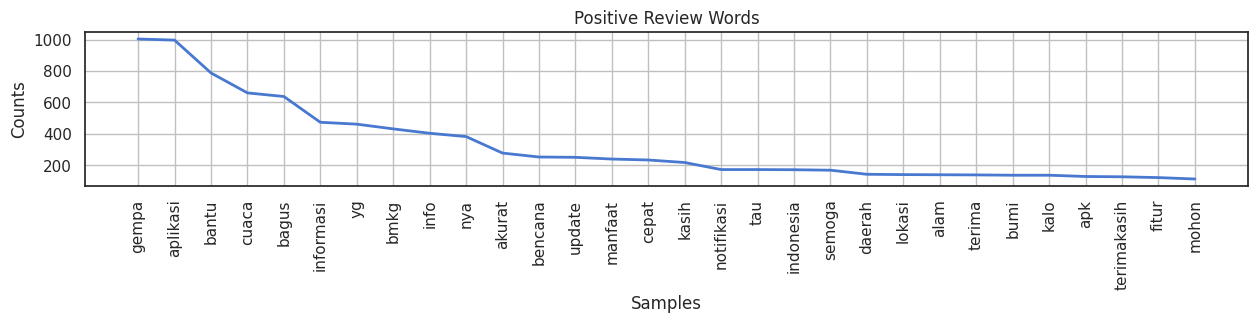

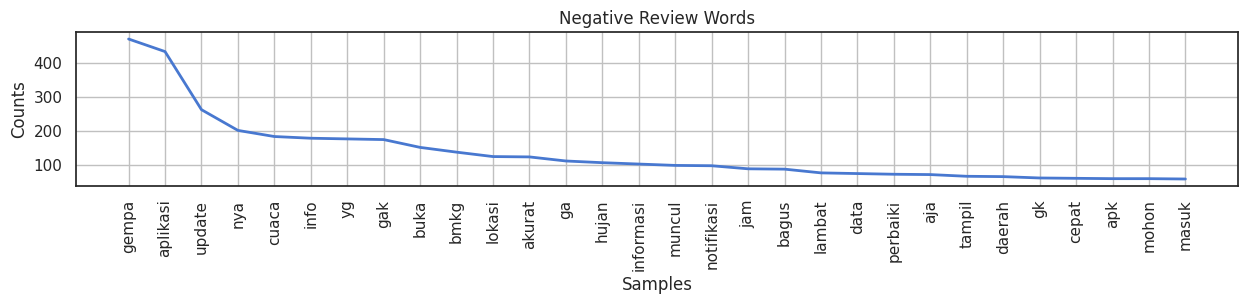

In [ ]:
# visualisasi top 30 kata
plt.figure(figsize=(15,2))
positive_freq_dic.plot(30,  title='Positive Review Words');

plt.figure(figsize=(15,2))
negative_freq_dic.plot(30, title='Negative Review Words');

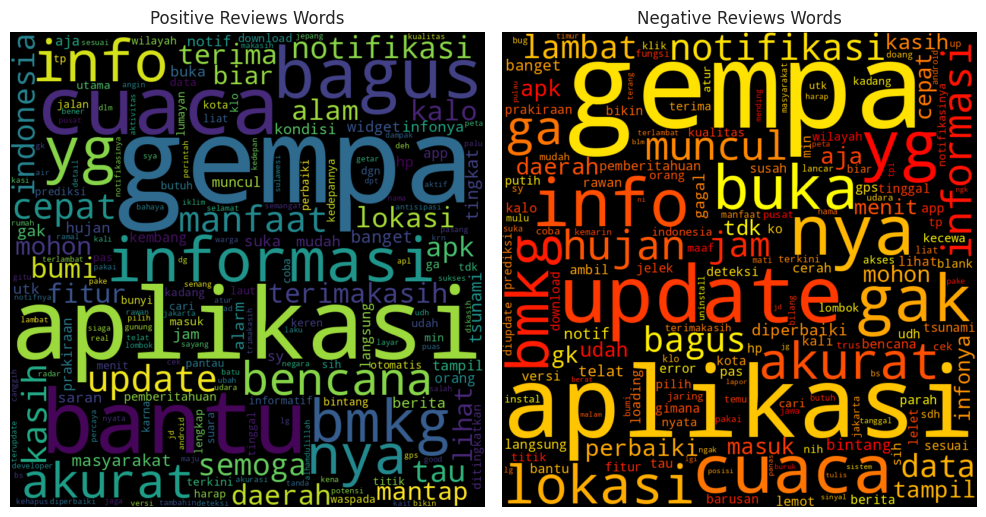

In [ ]:
def plot_important_words(pos_dic, neg_dic):
    fig, ax=plt.subplots(ncols=2, figsize=(10,10))

    wc = WordCloud(background_color='black',\
                min_font_size=8, width=800, height=800,\
                        colormap=None ).generate_from_frequencies(pos_dic)
    ax[0].imshow(wc, interpolation='bilinear')
    ax[0].set_title('Positive Reviews Words')
    ax[0].axis('off');

    wc = WordCloud(background_color='black',\
               min_font_size=12, width=800, height=800,\
                     colormap='autumn' ).generate_from_frequencies(neg_dic)
    ax[1].imshow(wc, interpolation='bilinear' )
    ax[1].set_title('Negative Reviews Words')
    ax[1].axis('off');

    fig.set_tight_layout({'pad':1})

plot_important_words(positive_freq_dic, negative_freq_dic)

In [ ]:
pos=set(x[0] for x in positive_freq_dic.most_common(20))
neg=set(x[0] for x in negative_freq_dic.most_common(20))

print(neg & pos)
print('\nDari', len(neg), 'kata terdapat', len(neg & pos), 'yang sama')

{'informasi', 'aplikasi', 'bmkg', 'akurat', 'gempa', 'bagus', 'info', 'nya', 'notifikasi', 'yg', 'update', 'cuaca'}

Dari 20 kata terdapat 12 yang sama


In [ ]:
pos=set(x[0] for x in positive_freq_dic.most_common(100))
neg=set(x[0] for x in negative_freq_dic.most_common(100))

print(neg & pos)
print('\nDari', len(neg), 'kata terdapat', len(neg & pos), 'yang sama')

{'hujan', 'informasi', 'gempa', 'kalo', 'titik', 'berita', 'lihat', 'nya', 'daerah', 'download', 'yg', 'tdk', 'tsunami', 'update', 'muncul', 'langsung', 'perbaiki', 'bmkg', 'akurat', 'kasih', 'notif', 'aja', 'bagus', 'sih', 'notifikasi', 'udah', 'kota', 'wilayah', 'pemberitahuan', 'bintang', 'aplikasi', 'infonya', 'fitur', 'min', 'cepat', 'lokasi', 'app', 'pas', 'data', 'indonesia', 'tau', 'menit', 'bencana', 'jam', 'banget', 'buka', 'apk', 'hp', 'cuaca', 'orang', 'bantu', 'terima', 'prakiraan', 'ga', 'info', 'mohon', 'cari', 'prediksi', 'gak', 'tampil', 'masuk', 'tinggal'}

Dari 100 kata terdapat 62 yang sama


In [ ]:
more_stop_word =[
    'atidakr', 'sama', 'saya', 'kalau', 'terjadi', 'untuk', 'jam', 'dini', 'tidak',
    'yang', 'bisa', 'di', 'baik', 'lama', 'lebih', 'apa', 'selalu', 'notif', 'kejadian',
    'padahal', 'bencana', 'terimakasih', 'ada', 'santidakt', 'apk', 'banget', 'banyak',
    'cuaca', 'notifikasi', 'kasih', 'hujan', 'buka', 'masuk', 'lokasi', 'sering', 'terus',
    'baru', 'app', 'jutidak', 'dulu', 'sekali', 'update', 'buat', 'kurang', 'terima', 'akurat',
    'tsunami', 'malah', 'jadi', 'baru', 'tsunami', 'semotidak', 'kok', 'alarm', 'hp', 'mengambil',
    'saran', 'indonesia', 'santidakt', 'jutidak', 'jutidak', 'apk', 'infonya', 'notifikasi', 'peringatan',
    'sayarat', 'tdk', 'terbaru', 'hujan', 'dentidakn', 'cuacanya', 'terima', 'mohon', 'barusan', 'semoga',
    'kejadian', 'muncul', 'langsung', 'kasih', 'terimakasih', 'aplikasi', 'perintidaktan', 'tingtidakl',
    'pengguna', 'tau', 'prediksi', 'info', 'biar', 'banget', 'update', 'jantidakn', 'fitur', 'ngtidak',
    'prakiraan', 'sih', 'masuk', 'gps', 'app', 'gempanya', 'data', 'nya', 'jam', 'hp', 'menit', 'kota',
    'ngtidak', 'bencana', 'daerah', 'cepat', 'buka', 'pas', 'aplikasinya', 'sesuai', 'santidakt', 'alam',
    'tampilan', 'bagus', 'pemberitahuan', 'titik', 'wilayah', 'bmkg', 'versi', 'msudah','gempa', 'min', 'ga',
    'notif', 'cuaca', 'lokasi', 'developer', 'informasi', 'bumi', 'tidaktidak1', 'masayaarakat', 'berawan', 'batidakimana',
    'perbaiki', 'widget', 'kadang', 'download', 'orang', 'klo', 'sehingtidak', 'diperbaiki', 'jepang', 'mentidakmbil',
    'bunyi', 'tidaktidakl', 'perkiraan', 'gk', 'bintang', 'cerah', 'bikin', 'kali', 'dibuka', 'ditingkatkan', 'tingtidak1', 'membantu',
    'yg', 'gak', 'aja', 'masyarakat', 'lihat', 'tingkat', 'kalo', 'bantu', 'udah', 'tampil', 'kembang', 'utk', 'ambil', 'berita',
    'kondisi', 'laut', 'pantau', 'suara', 'deteksi', 'jalan', 'terkini', 'sy'
]


positive2_freq_dic={key:value for key,value in positive_freq_dic.items() if key not in more_stop_word}
negative2_freq_dic={key:value for key,value in negative_freq_dic.items() if key not in more_stop_word}

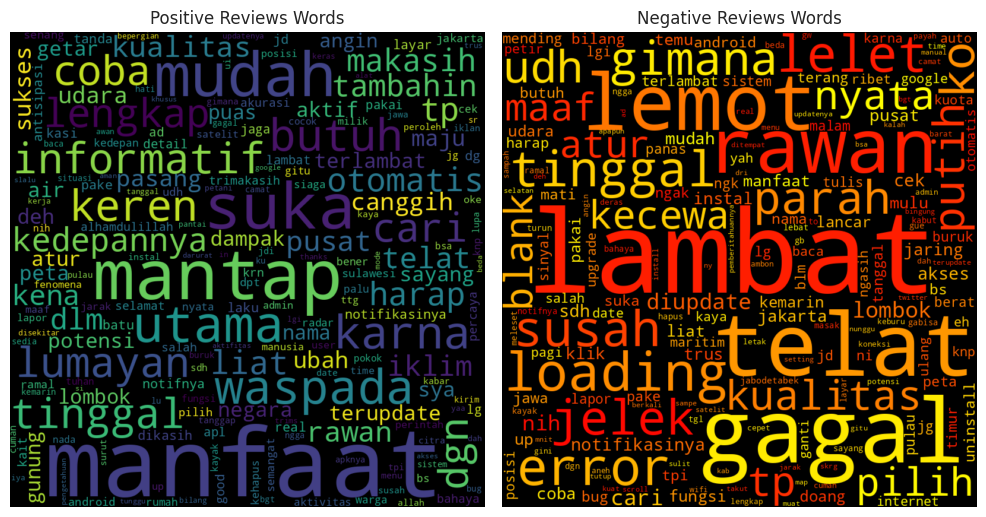

In [ ]:
plot_important_words(positive2_freq_dic, negative2_freq_dic)

In [ ]:
# stopword removal pt2
def more_stopword(content):
  content = [word for word in content if word not in more_stop_word]
  return content

df['content_lemma'] = df['content_lemma'].apply(lambda x: more_stopword(x))

In [ ]:
df.head()

,content,score,content_lemma
0,"[aplikasi, sangat, membantu, tapi, sayanga, da...",Positive,"[sayanga, srby, jangkau, selesai, suka]"
2,"[kami, meŕasa, terbantu, dlm, keadaan, dan, ko...",Positive,"[meŕasa, dlm, terjadikaml, bs, laku, upaya, aman]"
3,"[notifnya, kenapa, mati, ya, hari, ini]",Positive,"[notifnya, mati]"
4,"[sangat, membantu, utk, mengetahui, cuaca, dan...",Positive,"[jdi, lebi, waspada, krn]"
5,"[ut, cuaca, cukup, akurat]",Positive,[ut]


In [ ]:
# stemming
def stemming(content):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  text = []
  for i in content:
    x = stemmer.stem(i)
    text.append(x)
  content_clean = []
  content_clean = ' '.join(text)
  return content_clean

df['content_stemm'] = df['content_lemma'].apply(lambda x: stemming(x))
df.to_csv('bmkg_prepross_data.csv', index=False)

In [ ]:
path = '/content/bmkg_prepross_data.csv'

df_prepross = pd.read_csv(path)
df_prepross.head()

,content,score,content_lemma,content_stemm
0,"['aplikasi', 'sangat', 'membantu', 'tapi', 'sa...",Positive,"['sayanga', 'srby', 'jangkau', 'selesai', 'suka']",sayanga srby jangkau selesai suka
1,"['kami', 'meŕasa', 'terbantu', 'dlm', 'keadaan...",Positive,"['meŕasa', 'dlm', 'terjadikaml', 'bs', 'laku',...",me asa dlm terjadikaml bs laku upaya aman
2,"['notifnya', 'kenapa', 'mati', 'ya', 'hari', '...",Positive,"['notifnya', 'mati']",notifnya mati
3,"['sangat', 'membantu', 'utk', 'mengetahui', 'c...",Positive,"['jdi', 'lebi', 'waspada', 'krn']",jdi lebi waspada krn
4,"['ut', 'cuaca', 'cukup', 'akurat']",Positive,['ut'],ut


In [ ]:
df_prepross.shape

(4430, 4)

In [ ]:
df_prepross.isnull().sum()

,0
content,0
score,0
content_lemma,0
content_stemm,533


In [ ]:
df_clean = df_prepross.dropna()

In [ ]:
df_clean.shape

(3897, 4)

In [ ]:
df_clean.head()

,content,score,content_lemma,content_stemm
0,"['aplikasi', 'sangat', 'membantu', 'tapi', 'sa...",Positive,"['sayanga', 'srby', 'jangkau', 'selesai', 'suka']",sayanga srby jangkau selesai suka
1,"['kami', 'meŕasa', 'terbantu', 'dlm', 'keadaan...",Positive,"['meŕasa', 'dlm', 'terjadikaml', 'bs', 'laku',...",me asa dlm terjadikaml bs laku upaya aman
2,"['notifnya', 'kenapa', 'mati', 'ya', 'hari', '...",Positive,"['notifnya', 'mati']",notifnya mati
3,"['sangat', 'membantu', 'utk', 'mengetahui', 'c...",Positive,"['jdi', 'lebi', 'waspada', 'krn']",jdi lebi waspada krn
4,"['ut', 'cuaca', 'cukup', 'akurat']",Positive,['ut'],ut


In [ ]:
df_clean.rename(columns={'content': 'review', 'score': 'sentiment'}, inplace=True)
df_clean.head()

,review,sentiment,content_lemma,content_stemm
0,"['aplikasi', 'sangat', 'membantu', 'tapi', 'sa...",Positive,"['sayanga', 'srby', 'jangkau', 'selesai', 'suka']",sayanga srby jangkau selesai suka
1,"['kami', 'meŕasa', 'terbantu', 'dlm', 'keadaan...",Positive,"['meŕasa', 'dlm', 'terjadikaml', 'bs', 'laku',...",me asa dlm terjadikaml bs laku upaya aman
2,"['notifnya', 'kenapa', 'mati', 'ya', 'hari', '...",Positive,"['notifnya', 'mati']",notifnya mati
3,"['sangat', 'membantu', 'utk', 'mengetahui', 'c...",Positive,"['jdi', 'lebi', 'waspada', 'krn']",jdi lebi waspada krn
4,"['ut', 'cuaca', 'cukup', 'akurat']",Positive,['ut'],ut


In [ ]:
df_clean.reset_index(drop=True, inplace=True)
df_clean.head()

,review,sentiment,content_lemma,content_stemm
0,"['aplikasi', 'sangat', 'membantu', 'tapi', 'sa...",Positive,"['sayanga', 'srby', 'jangkau', 'selesai', 'suka']",sayanga srby jangkau selesai suka
1,"['kami', 'meŕasa', 'terbantu', 'dlm', 'keadaan...",Positive,"['meŕasa', 'dlm', 'terjadikaml', 'bs', 'laku',...",me asa dlm terjadikaml bs laku upaya aman
2,"['notifnya', 'kenapa', 'mati', 'ya', 'hari', '...",Positive,"['notifnya', 'mati']",notifnya mati
3,"['sangat', 'membantu', 'utk', 'mengetahui', 'c...",Positive,"['jdi', 'lebi', 'waspada', 'krn']",jdi lebi waspada krn
4,"['ut', 'cuaca', 'cukup', 'akurat']",Positive,['ut'],ut


In [ ]:
df_clean.sample(10)

,review,sentiment,content_lemma,content_stemm
707,"['sudah', 'lama', 'download', 'baru', 'di', 'u...",Negative,"['klau', 'otomatis']",klau otomatis
885,"['semoga', 'semakin', 'update', 'memberikan', ...",Positive,['manfaat'],manfaat
3890,"['bagustingkatkan', 'kualitas']",Positive,"['bagustingkatkan', 'kualitas']",bagustingkatkan kualitas
3632,"['semoga', 'semakin', 'banyak', 'invo', 'akura...",Positive,"['invo', 'shg', 'manfaat', 'jg', 'terdampa']",invo shg manfaat jg terdampa
401,"['sangat', 'terbantu', 'dlm', 'mendapatkan', '...",Positive,"['dlm', 'khusus']",dlm khusus
1862,"['mantap', 'dan', 'tingkatkan', 'terus', 'krea...",Positive,"['mantap', 'kreatif']",mantap kreatif
3067,"['saya', 'sangat', 'terbantu', 'dengan', 'apli...",Positive,['memperdisikan'],memperdisikan
3240,"['infonya', 'lambat', 'kadang', 'gak', 'terupd...",Negative,"['lambat', 'terupdate']",lambat terupdate
3269,"['sedikit', 'masukan', 'kalau', 'bisa', 'ditam...",Positive,"['citra', 'radar', 'uptodate', 'gambar', 'seki...",citra radar uptodate gambar sekira turun inten...
1659,"['aplikasi', 'ini', 'sangat', 'membantu', 'bua...",Positive,"['betada', 'dipesisir', 'pantai', 'konawe', 'u...",betada pesisir pantai konawe utara


In [ ]:
df_clean.to_csv('bmkg_clean_data.csv')

## Feature Engineering

### TF-IDF

In [ ]:
tfidf = TfidfVectorizer(
    use_idf=True,
    smooth_idf=True,
    max_features=1500
)

response = tfidf.fit_transform(df_clean['content_stemm'])

df_tfidf = pd.DataFrame(
    response.toarray(),
    columns=tfidf.get_feature_names_out()
)

df_tfidf.head()

,aamiin,abai,abis,absen,abu,aceh,ad,ada,adala,adaptasi,...,wkwkwk,yaa,yaaa,yaaaa,yah,yng,you,youtube,zona,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Word2Vec

In [ ]:
sentences = []
for content_lemma in df['content_lemma']:
  sentences.append(word_tokenize(" ".join(content_lemma)))

sentences = [sentence for sentence in sentences if sentence]
sentences[:10]

[['sayanga', 'srby', 'jangkau', 'selesai', 'suka'],
 ['meŕasa', 'dlm', 'terjadikaml', 'bs', 'laku', 'upaya', 'aman'],
 ['notifnya', 'mati'],
 ['jdi', 'lebi', 'waspada', 'krn'],
 ['ut'],
 ['perintah', 'pakek'],
 ['kitaterimakasih'],
 ['manfaat'],
 ['handal', 'sukses', 'selaluaamiin'],
 ['kalok', 'bener', 'ujan', 'tpi', 'ujan', 'nih', 'denpasar', 'php', 'lu']]

In [ ]:
w2vec = Word2Vec(
    sentences,
    vector_size=100,
    window=5,
    min_count=3,
    sg=0
)

w2vec.save('word2vec.model')

In [ ]:
model_w2vec = Word2Vec.load('word2vec.model')

In [ ]:
w2v = model_w2vec.wv
w2v.index_to_key[:10]

['manfaat',
 'mantap',
 'suka',
 'mudah',
 'lambat',
 'telat',
 'tinggal',
 'utama',
 'rawan',
 'butuh']

In [ ]:
w2v.most_similar('rawan')

[('negara', 0.825121283531189),
 ('sdh', 0.8155187368392944),
 ('tinggal', 0.8127336502075195),
 ('karna', 0.8029749989509583),
 ('pilih', 0.7977258563041687),
 ('nama', 0.7891664505004883),
 ('jawa', 0.7890732288360596),
 ('angin', 0.7882232069969177),
 ('getar', 0.7873562574386597),
 ('suka', 0.785953164100647)]

## Eksploratory Data Analysis (EDA)

### Sanity Check

In [ ]:
reducer = UMAP()
X_umap = reducer.fit_transform(response.toarray())

df_clean['umap_1'] = X_umap[:, 0]
df_clean['umap_2'] = X_umap[:, 1]

df_clean['sentiment'] = df_clean['sentiment'].map({'Positive': 1, 'Negative': 0})

fig = px.scatter(df_clean, x='umap_1', y='umap_2', color='sentiment', title='UMAP Visualization of BMKG App Reviews Use Tf-Idf', text='content_stemm')
fig.update_layout(height=650)
fig.show()

In [ ]:
X = UMAP().fit_transform(w2v.vectors)

df2 = pd.DataFrame(X, columns=['umap1', 'umap2'])
df2['word'] = w2v.index_to_key

fig = px.scatter(df2, x='umap1', y='umap2', text='word')
fig.update_traces(textposition='top center')
fig.update_layout(height = 800,
                  title_text = 'Word2Vec Visualization')
fig.show()

### WordCloud

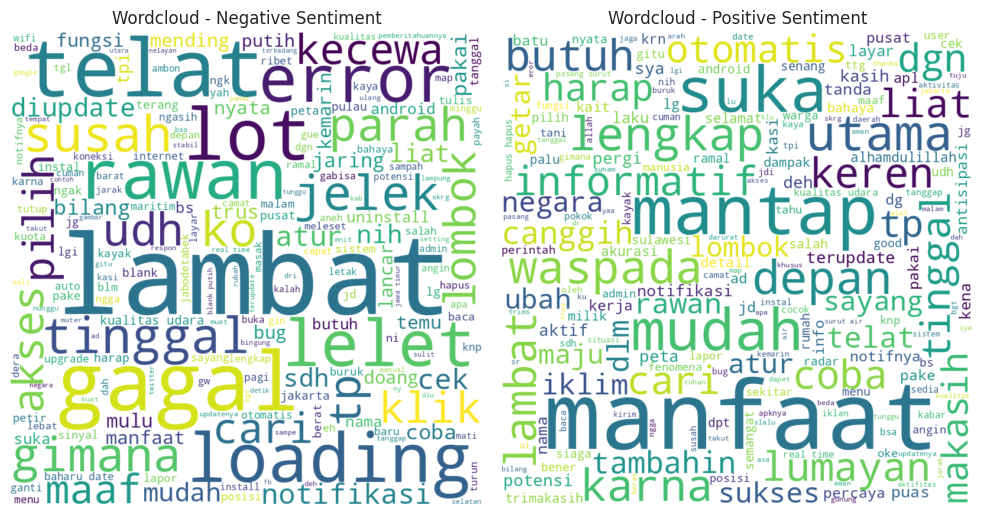

In [ ]:
neg_sen = df_clean[df_clean['sentiment'] == 0]['content_stemm'].str.cat(sep=' ')
pos_sen = df_clean[df_clean['sentiment'] == 1]['content_stemm'].str.cat(sep=' ')

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
wordcloud_neg = WordCloud(width=800, height=800, background_color='white').generate(neg_sen)
plt.imshow(wordcloud_neg, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud - Negative Sentiment')

plt.subplot(1, 2, 2)
wordcloud_pos = WordCloud(width=800, height=800, background_color='white').generate(pos_sen)
plt.imshow(wordcloud_pos, interpolation='bilinear')
plt.axis('off')
plt.title('Wordcloud - Positive Sentiment')

plt.tight_layout()
plt.show()